Drzewa decyzyjne
---

Zaczniemy od próby wytrenowania drzewa na zbiorze syntetycznym. W tym celu wygenerujemy dane syntetyczne.|

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [43]:
# losowe dane dla dwóch klas, przy przesunięciu środka rozkładu
train_data = np.vstack((np.random.normal(size=(100, 2)),
                        np.random.normal(size=(100, 2), loc=2)))
train_labels = np.hstack((np.zeros(100), np.ones(100)))

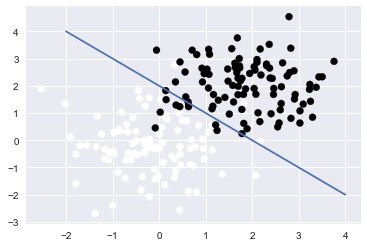

In [44]:
fig, ax = plt.subplots()
ax.scatter(train_data[:, 0], train_data[:, 1], c=train_labels)
ax.plot(range(-2, 5), range(4, -3, -1))
plt.show()

Spróbujmy wytrenować na nich klasyfikator i zwalidować go.

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [46]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [47]:
clf = DecisionTreeClassifier()

clf.fit(train_data, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

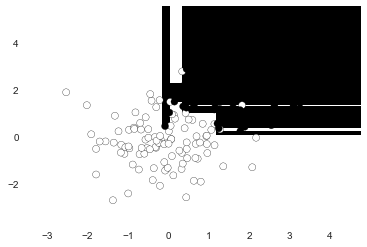

In [48]:
xs, ys = get_grid(train_data)

predicted = clf.predict(
    np.column_stack((xs.flatten(),
                     ys.flatten()))).reshape(xs.shape)

fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, predicted)
ax.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, edgecolors='k')
plt.show()

Wyświetlanie drzewa - by zbadać parametry i progi

In [49]:
from sklearn.tree import plot_tree

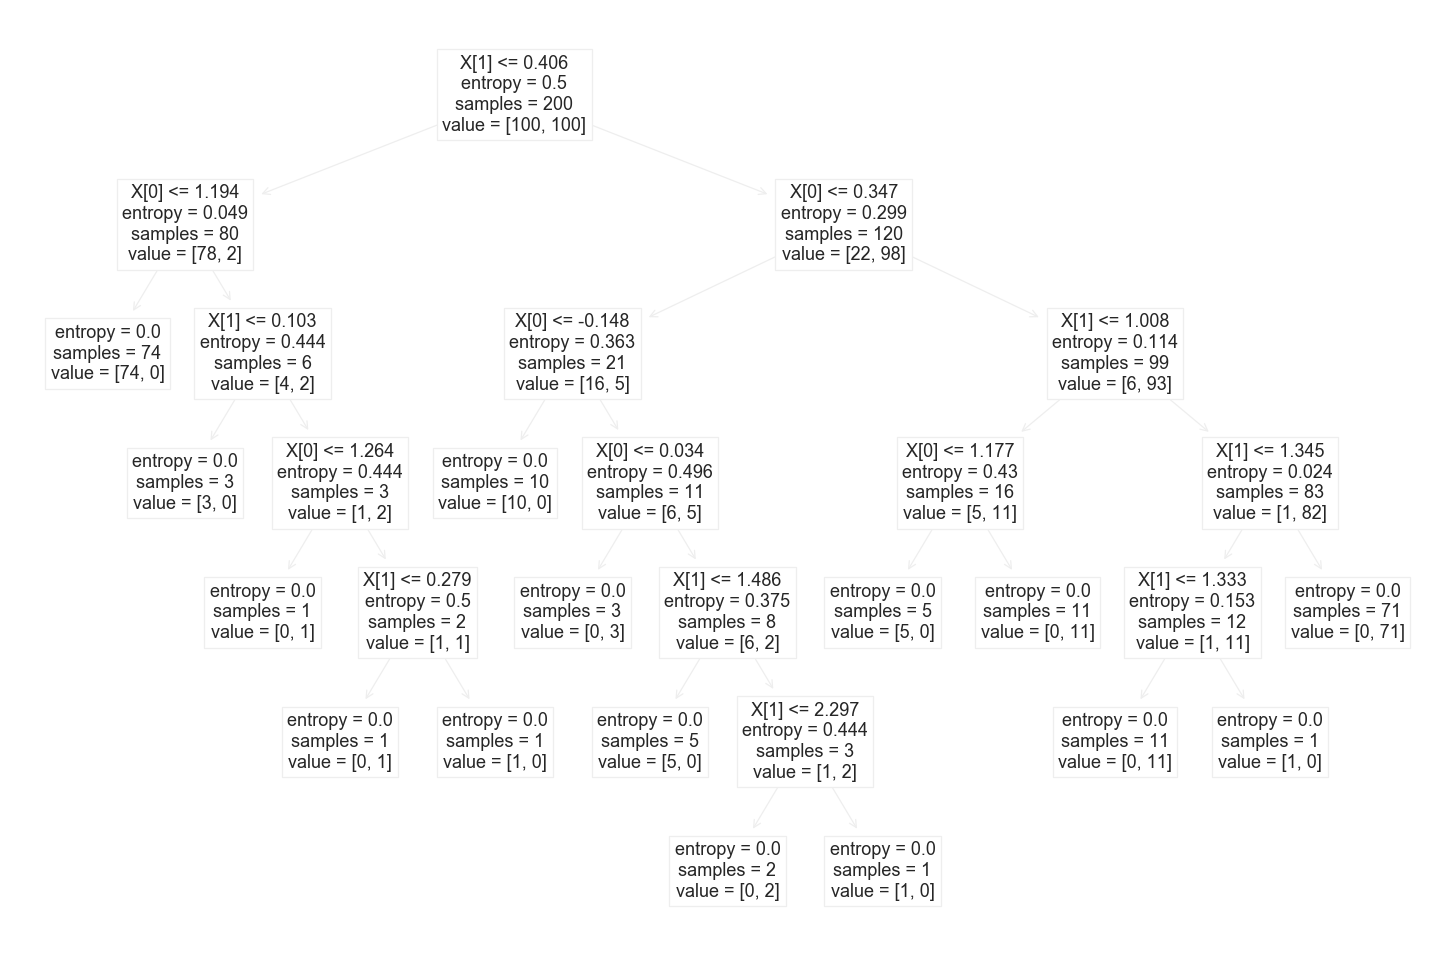

In [50]:
plt.figure(dpi=300)
plot_tree(clf)
plt.show()

Próba na rzeczywistych danych - w oparciu o podejście z naiwnego klasyfikatora bayesowskiego

In [51]:
!git clone https://github.com/PiotrJZielinski/ml-throwdown-datasets


fatal: destination path 'ml-throwdown-datasets' already exists and is not an empty directory.


In [52]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ml-throwdown-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'}}
    dataset, classes = load_dataset(dataset_name,
                                    **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes

In [53]:
from sklearn.preprocessing import Normalizer, StandardScaler

def preprocess_data(X, preprocessor=None):
    if preprocessor is not None:
        preprocessor.fit(X)
        X_preprocessed = X.copy()
        X_preprocessed[:] = preprocessor.transform(X.values)
        X = X_preprocessed
    return X

In [54]:
import pandas as pd
import numpy as np

def equal_length(column, n_bins):
    # metoda pandasa do podziału zbioru na jednakową frakwencję (częstość)
    indices, bins = pd.cut(column, n_bins, labels=False, retbins=True, duplicates='drop')
    return indices.map(dict(enumerate(bins)))

def equal_frequency(column, n_bins):
    # metoda pandasa do podziału zbioru na jednakową frakwencję (częstość)
    indices, bins = pd.qcut(column, n_bins, labels=False, retbins=True, duplicates='drop') 
    return indices.map(dict(enumerate(bins)))

def automatic_binning(column):
    # podział na przedziały zależy tu od histogramu
    _, bins = np.histogram(column, bins='fd')
    indices = pd.Series(np.digitize(column, bins) - 1)
    return indices.map(dict(enumerate(bins)))

def bin_data(X, binning=None):
    if binning is not None:
        X = X.apply(binning)
    return X

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='micro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')
    
def plot_confusion_matrix(confusion_matrix, classes, title=None,
                          title_appendix='',
                          cmap=plt.cm.Blues):
    # tytuł wykresu
    if title_appendix:
        title_appendix = f'({title_appendix})'
    if title is None:
        title = f'Confusion matrix {title_appendix}'
    
    fig, ax = plt.subplots()
    # rysuje CM
    img = ax.imshow(confusion_matrix, cmap=cmap)
    # dodaje pasek z boku
    ax.figure.colorbar(img, ax=ax)
    # dodatki do wykresu
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    # etykiety
    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                    ha='center', va='center',
                    color='white' if cell > thresh else 'black')
    fig.tight_layout()
    
    return ax

def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype(
        'float') / confusion_matrix.sum(
        axis=1)[np.newaxis].T

In [56]:
X, y, classes = prepare_dataset('iris')
X = preprocess_data(X)
X = bin_data(X)
X.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [58]:
from sklearn.tree import DecisionTreeClassifier

In [59]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_dt = dt.predict(X_test)

Results for Decision Tree
----
  Accuracy:  0.9666666666666667
  Precision: 0.9666666666666667
  Recall:    0.9666666666666667
  F1 score:  0.9666666666666667
  Mislabeled 1 out of 30




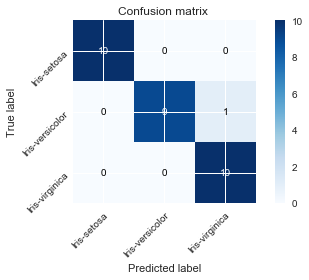

In [60]:
print_results(calculate_metrics(y_test.values, y_dt), 'Decision Tree')
cm = confusion_matrix(y_test, y_dt)
plot_confusion_matrix(cm, classes)

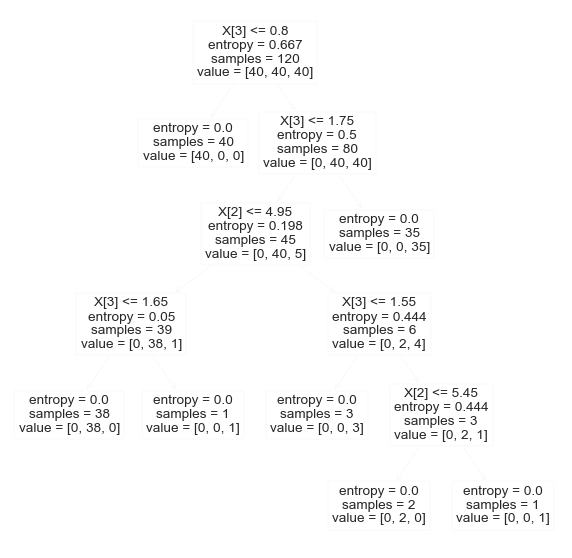

In [61]:
plt.figure(figsize=(10, 10))
plot_tree(dt)
plt.show()

In [62]:
from sklearn.model_selection import KFold, StratifiedKFold

def cross_validate(classifier, kfold, X, y, classes, params=None, talk=True):
    if params is None:
        params = {}
    if classifier.__class__.__name__ == 'ABCMeta':
        clf = classifier(**params)
    else:
        clf = classifier
    predicted = []
    target = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X=X_train, y=y_train)
        predicted = np.concatenate((predicted, clf.predict(X_test)))
        target = np.concatenate((target, y_test))
    
    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    if talk:
        print_results(metrics, clf.__class__.__name__)
        plot_confusion_matrix(normalize_confusion_matrix(cm),
                              classes,
                              title_appendix=clf.__class__.__name__)
        plt.show()
    else:
        return metrics, cm

Results for DecisionTreeClassifier
----
  Accuracy:  0.96
  Precision: 0.96
  Recall:    0.96
  F1 score:  0.96
  Mislabeled 6 out of 150




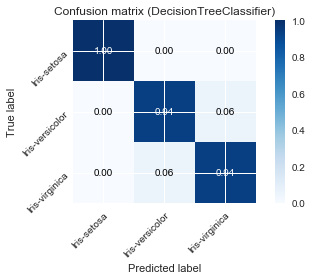

In [63]:
cross_validate(DecisionTreeClassifier(), StratifiedKFold(10), X, y, classes)

In [66]:
def plot_results(result_df, title, plot_type='bar'):
    ind = np.arange(len(result_df))
    fig, ax = plt.subplots(figsize=(20, 10))
    width = 1 / len(result_df.columns)
    if plot_type == 'bar':
        plot = lambda index, data, label: ax.bar(index, data, width=width, label=label)
    elif plot_type == 'plot':
        plot = lambda index, data, label: ax.plot(index, data, label=label)
    plot(ind, result_df['accuracy'], 'Accuracy')
    plot(ind+width, result_df['precision'], 'Precision')
    plot(ind+2*width, result_df['recall'], 'Recall')
    plot(ind+3*width, result_df['fscore'], 'fscore')
    
    ax.set_title(title)
    ax.set_ylabel('Scores')
    ax.set_xlabel(result_df.index.name)
    ax.set_xticks(ind + 3 * width / 2)
    ax.set_xticklabels(result_df.index)
    ax.autoscale()
    ax.legend()
    return ax

In [67]:
def test_params(X, y, classes, classifier, classifier_param, classifier_const_params=None,
                kfold=None,
                normalizer=None, binning=None):
    if classifier_const_params is None:
        classifier_const_params = {}
    if kfold is None:
        kfold = StratifiedKFold(10)
    X = preprocess_data(X, normalizer)
    X = bin_data(X, binning)
    param = list(classifier_param.keys())[0]
    data = {param: [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, value in enumerate(list(classifier_param.values())[0]):
        kwargs = {param: value}
        clf = classifier(**kwargs, **classifier_const_params)
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(clf,
                                     kfold,
                                     X, y, classes,
                                     talk=False)
        data[param].append(value)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index(param)
    return plot_results(df, f'{clf.__class__.__name__} - {param}', plot_type='plot'), df


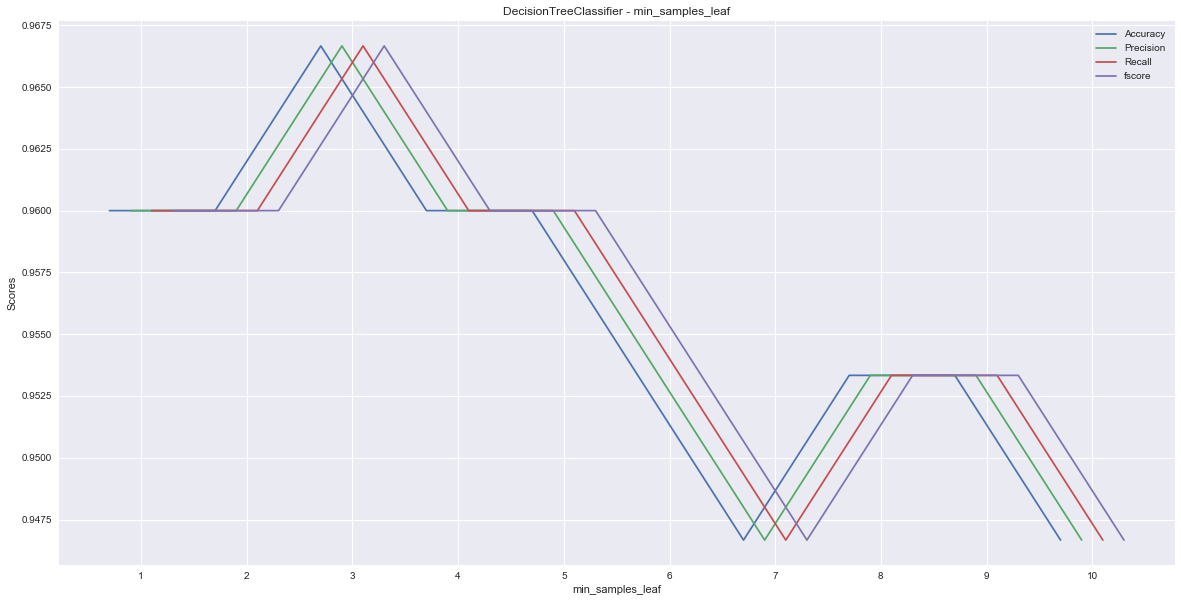

,accuracy,precision,recall,fscore,cm
min_samples_leaf,,,,,
1,0.960000,0.960000,0.960000,0.960000,"[[50, 0, 0], [0, 47, 3], [0, 3, 47]]"
2,0.960000,0.960000,0.960000,0.960000,"[[50, 0, 0], [0, 47, 3], [0, 3, 47]]"
3,0.966667,0.966667,0.966667,0.966667,"[[50, 0, 0], [0, 47, 3], [0, 2, 48]]"
4,0.960000,0.960000,0.960000,0.960000,"[[50, 0, 0], [0, 48, 2], [0, 4, 46]]"
5,0.960000,0.960000,0.960000,0.960000,"[[50, 0, 0], [0, 48, 2], [0, 4, 46]]"
6,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 48, 2], [0, 5, 45]]"
7,0.946667,0.946667,0.946667,0.946667,"[[50, 0, 0], [0, 47, 3], [0, 5, 45]]"
8,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 48, 2], [0, 5, 45]]"
9,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 48, 2], [0, 5, 45]]"


In [70]:
ax, results = test_params(X, y, classes,
                          DecisionTreeClassifier,
                          {'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
plt.show()
results

In [25]:
def test_classifiers(X, y, classes,
                     classifiers,
                     kfold=None,
                     normalizer=None, binning=None):
    if kfold is None:
        kfold = StratifiedKFold(10)
    X = preprocess_data(X, normalizer)
    X = bin_data(X, binning)
    data = {'classifier': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, classifier in enumerate(classifiers):
        name =  f"{classifier.__class__.__name__}-{index}"
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X, y, classes,
                                     talk=False)
        data['classifier'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('classifier')
    return plot_results(df, 'Classifiers comparison'), df

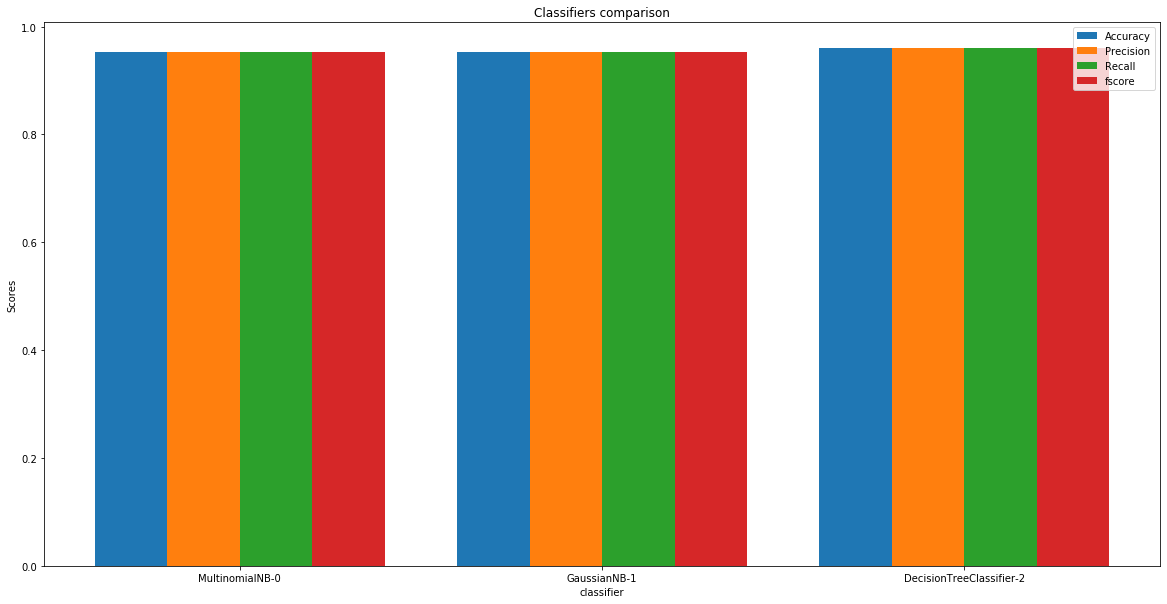

,accuracy,precision,recall,fscore,cm
classifier,,,,,
MultinomialNB-0,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 46, 4], [0, 3, 47]]"
GaussianNB-1,0.953333,0.953333,0.953333,0.953333,"[[50, 0, 0], [0, 47, 3], [0, 4, 46]]"
DecisionTreeClassifier-2,0.960000,0.960000,0.960000,0.960000,"[[50, 0, 0], [0, 47, 3], [0, 3, 47]]"


In [26]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

ax, results = test_classifiers(X, y, classes,
                               [MultinomialNB(), GaussianNB(),
                                DecisionTreeClassifier()])
plt.show()
results